# Model Building

I will now be testing the data on a comprehensive list of classifying models to determine which ones will be the most accurate in labeling the reddit posts.

In [3]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_colwidth = 200

In [4]:
# Reading in the saved CSV file

reddit = pd.read_csv('../datasets/reddit_slimmed_no_https.csv')
reddit.drop(columns='Unnamed: 0', inplace=True)
reddit.head()

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,ohio,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,ohio,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,ohio,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77
3,ohio,ranked choice voting?,"alaska seems to be doing well, when does ohio follow.",titanup1993,3,10
4,ohio,how long is the wait for a handgun purchased from atlantic gun &amp; tackle,not sure if this is the right place to be asking. but i recently just purchased a handgun from atlantic gun &amp; tackle and they said i could get approved today in the next hour or it could be up...,professional_pie4546,14,84


---

## Establishing the Baseline

In [5]:
reddit['subreddit_class'] = reddit['subreddit_class'].map({'ohio': 0, 'ihateohio': 1})

reddit.head(3)

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,0,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,0,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,0,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77


In [6]:
X = reddit['title']
y = reddit['subreddit_class']

y.value_counts(normalize=True)

1    0.522182
0    0.477818
Name: subreddit_class, dtype: float64

This baseline is telling us that if we predicted that all posts were from the Ohio subreddit, we'd be correct 52.22% of the time.

I'll be running all models on both the selftext and title columns with no hyperparameters. This is because I want to evaluate the scores of the models alone and choose a handful of the top-performers to begin tuning with GridSearch until one becomes the clear champion.

Because sensitivity and specificity are not critically important in this case, I'll also be looking at the accuracy and misclassification rates for all models, and aiming to optimize for testing r2 scores (overall accuracy) when I begin running trials with hyperparameters included.

---

## Building a Function to Expedite Model Trials

Because I am going to be cycling through several different models in this next section, I think having a function to do most of the heavy lifting would streamline the process. 

In [7]:
model_trials_df = pd.DataFrame(columns=['model_used', 'title_train_score', 'title_test_score',
'selftext_train_score', 'selftext_test_score'])

In [8]:
def model_trials(pipe, model_id):

    '''Setting X and y to first use the title column as the predictor'''
    X_t = reddit['title']
    y_t = reddit['subreddit_class']
    X_train, X_test_t, y_train, y_test_t = train_test_split(X_t, y_t, test_size=0.2, stratify=y_t, random_state=42)
    pipe.fit(X_train, y_train)
    t_train_score = pipe.score(X_train, y_train)
    t_test_score = pipe.score(X_test_t, y_test_t)

    '''Calculating accuracy and misclassification rates for title'''
    t_preds = pipe.predict(X_test_t)
    tn, fp, fn, tp = confusion_matrix(y_test_t, t_preds).ravel()
    t_acc = (tp + tn) / (tn + fp + tp + fn)
    t_misclass = 1 - t_acc

    '''Now redefining X and y to analyze the selftext column'''
    X_st = reddit['selftext']
    y_st = reddit['subreddit_class']
    X_train, X_test_st, y_train, y_test_st = train_test_split(X_st, y_st, test_size=0.2, stratify=y_t, random_state=42)
    pipe.fit(X_train, y_train)
    st_train_score = pipe.score(X_train, y_train)
    st_test_score = pipe.score(X_test_st, y_test_st)

    '''Calculating accuracy and misclassification rates for selftext'''
    st_preds = pipe.predict(X_test_st)
    tn, fp, fn, tp = confusion_matrix(y_test_st, st_preds).ravel()
    st_acc = (tp + tn) / (tn + fp + tp + fn)
    st_misclass = 1 - st_acc

    '''Adding the two scores for both Xs to the model_trials dataframe'''
    model_list = [model_id, t_train_score, t_test_score, st_train_score, st_test_score]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show me all scores to see how they compare to each other'''
    print(f'Title {model_id} Training Score: {round(t_train_score, 5)}')
    print(f'Title {model_id} Testing Score: {round(t_test_score, 5)} \n')
    print(f'Selftext {model_id} Training Score: {round(st_train_score, 5)}')
    print(f'Selftext {model_id} Testing Score: {round(st_test_score, 5)} \n')
    print(f'Title Accuracy Rate: {round(t_acc, 5)}')
    print(f'Title Misclassification Rate: {round(t_misclass, 5)} \n')
    print(f'Selftext Accuracy Rate: {round(st_acc, 5)}')
    print(f'Selftext Misclassification Rate: {round(st_misclass, 5)} \n')

    '''Returning a confusion matrix for the predictor that had the highest accuracy'''
    print('Best accuracy rate confusion matrix:')
    if t_acc > st_acc:
        return plot_confusion_matrix(pipe, X_test_t, y_test_t, cmap='YlOrRd', values_format='d');
    else: 
        return plot_confusion_matrix(pipe, X_test_st, y_test_st, cmap='YlGnBu', values_format='d');

In each section, I'll define the pipeline I want to use, but the function should do the rest and spit out each of the training and testing scores for title and selftext. It will also append the scores to the overall dataframe that I'll be using after to decide which models to move forward with.

In the EDA portion of the project, I looked at the results pre- and post- lemmatizing the target columns and found that, on average, there is a negligible difference in the words that appear most frequently. For that reason, I will not be lemmatizing in the model trials or tuning.

---

## Logistic Regression

In [9]:
cvec_lr = Pipeline([
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression(max_iter=200, solver='saga', random_state=42)) # Hyperparameters added here to increase model iterations/avoid error messages
])

Title CVec Logistic Regression Training Score: 0.96327
Title CVec Logistic Regression Testing Score: 0.79341 

Selftext CVec Logistic Regression Training Score: 0.8988
Selftext CVec Logistic Regression Testing Score: 0.84731 

Title Accuracy Rate: 0.79341
Title Misclassification Rate: 0.20659 

Selftext Accuracy Rate: 0.84731
Selftext Misclassification Rate: 0.15269 

Best accuracy rate confusion matrix:


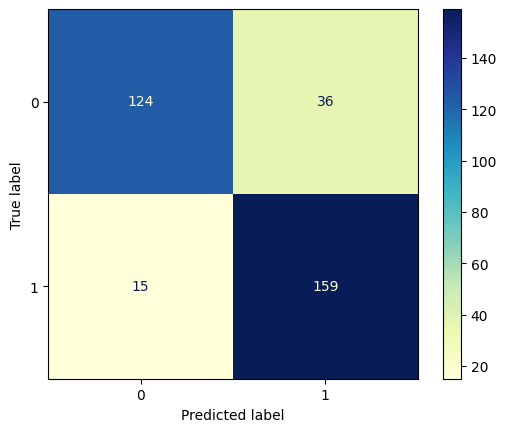

In [10]:
model_trials(cvec_lr, 'CVec Logistic Regression')

I'm curious to see if using the Tfidf Vectorizer would have any effect on any of the scores. Creating a new pipeline below that is exactly the same as above, with only the CountVectorizer edited. 

In [11]:
tfvec_lr = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('lr', LogisticRegression(max_iter=200, solver='saga', random_state=42))
])

Title TfVec Logistic Regression Training Score: 0.92954
Title TfVec Logistic Regression Testing Score: 0.76647 

Selftext TfVec Logistic Regression Training Score: 0.87031
Selftext TfVec Logistic Regression Testing Score: 0.82635 

Title Accuracy Rate: 0.76647
Title Misclassification Rate: 0.23353 

Selftext Accuracy Rate: 0.82635
Selftext Misclassification Rate: 0.17365 

Best accuracy rate confusion matrix:


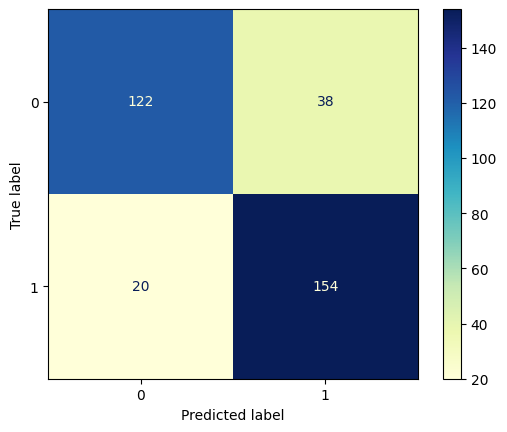

In [12]:
model_trials(tfvec_lr, 'TfVec Logistic Regression')

In [13]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347


### Analysis

These are both fairly solid starting models - although the title scores have quite a bit more variance than the selftext scores.

When we used Tfidf in place of CountVectorizer, both title and selftext scores decreased by a margin of 0.02 - 0.035.

In both test cases, the Logisitic Regression pipeline that used selftext as the feature performed better than the models that used the title as the variable. This may be because there are more definitive (easier to classify) words in the selftext/caption area of posts.

Because I believe that score differences may depend on the model/transformer combination used, I'll be running all with both CountVectorizer and TfidfVectorizer moving forward.

---

## Multinomial Naive Bayes

In [14]:
cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

Title CVec Mn Naive Bayes Training Score: 0.94378
Title CVec Mn Naive Bayes Testing Score: 0.79042 

Selftext CVec Mn Naive Bayes Training Score: 0.8973
Selftext CVec Mn Naive Bayes Testing Score: 0.82934 

Title Accuracy Rate: 0.79042
Title Misclassification Rate: 0.20958 

Selftext Accuracy Rate: 0.82934
Selftext Misclassification Rate: 0.17066 

Best accuracy rate confusion matrix:


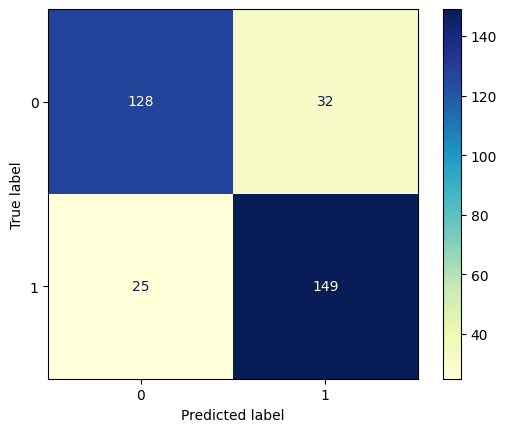

In [15]:
model_trials(cvec_mnb, 'CVec Mn Naive Bayes')

In [16]:
tfvec_mnb = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

Title TfVec Mn Naive Bayes Training Score: 0.94903
Title TfVec Mn Naive Bayes Testing Score: 0.77545 

Selftext TfVec Mn Naive Bayes Training Score: 0.85907
Selftext TfVec Mn Naive Bayes Testing Score: 0.81138 

Title Accuracy Rate: 0.77545
Title Misclassification Rate: 0.22455 

Selftext Accuracy Rate: 0.81138
Selftext Misclassification Rate: 0.18862 

Best accuracy rate confusion matrix:


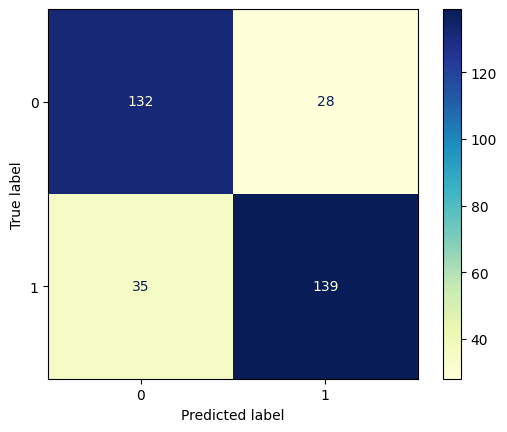

In [17]:
model_trials(tfvec_mnb, 'TfVec Mn Naive Bayes')

In [18]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347
2,CVec Mn Naive Bayes,0.943778,0.790419,0.897301,0.829341
3,TfVec Mn Naive Bayes,0.949025,0.775449,0.859070,0.811377


### Analysis

The Multinomial Naive Bayes model performed about the same as the Logistic Regression model on all scores. 

Based on the confusion matrices above, we see that Tfidf misclassified ten posts that were correctly classified by CountVectorizer. This may be because Tfidf and Multinomial Naive Bayes are working under different assumptions - Tfidf places value on relative frequency of a word, while MNB assumes that the frequency of all features are independent from one another and classifies in the same way.

All that said, the CountVectorizer/MNB model may be worth moving forward with in future trials.

---

## KNN Classifier

In [19]:
cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

Title CVec KNN Training Score: 0.6919
Title CVec KNN Testing Score: 0.55689 

Selftext CVec KNN Training Score: 0.62894
Selftext CVec KNN Testing Score: 0.5479 

Title Accuracy Rate: 0.55689
Title Misclassification Rate: 0.44311 

Selftext Accuracy Rate: 0.5479
Selftext Misclassification Rate: 0.4521 

Best accuracy rate confusion matrix:


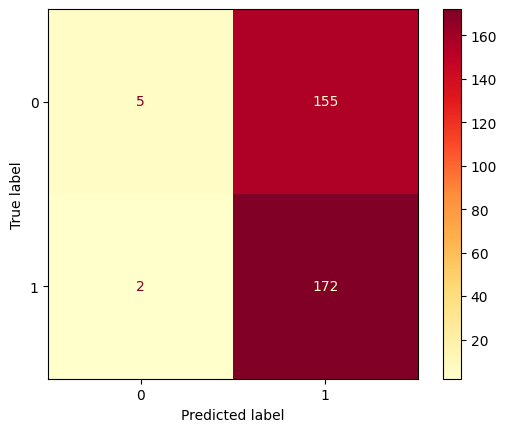

In [20]:
model_trials(cvec_knn, 'CVec KNN')

In [21]:
tfvec_knn = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

Title TfVec KNN Training Score: 0.61469
Title TfVec KNN Testing Score: 0.52695 

Selftext TfVec KNN Training Score: 0.52549
Selftext TfVec KNN Testing Score: 0.52096 

Title Accuracy Rate: 0.52695
Title Misclassification Rate: 0.47305 

Selftext Accuracy Rate: 0.52096
Selftext Misclassification Rate: 0.47904 

Best accuracy rate confusion matrix:


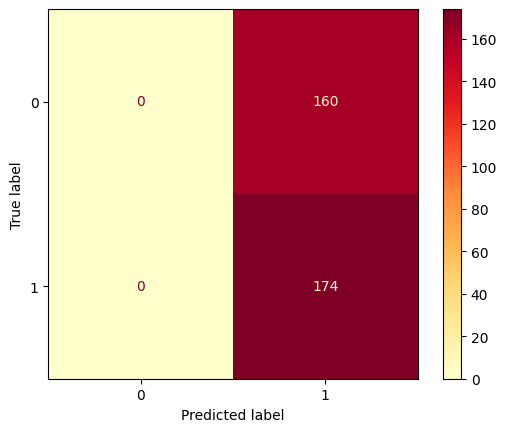

In [22]:
model_trials(tfvec_knn, 'TfVec KNN')

### Analysis

The KNN model performed about as well as the baseline score, and classified in a similar way.

In the model that used CountVectorizer, all but seven posts were predicted as being from the IHateOhio subreddit. When we switched to Tfidf, the model classified all posts as being from the IHateOhio subreddit.

I do think that the hyperparameters could be adjusted to likely produce a higher score, but given these scores as the baseline, KNN seems unlikely to outperform the Logistic Regression model or any others.

Introducing randomness into the model is needed to decrease the variance.

---

## Decision Tree Classifier

In [23]:
cvec_dtree = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

Title CVec Decision Tree Training Score: 0.997
Title CVec Decision Tree Testing Score: 0.72754 

Selftext CVec Decision Tree Training Score: 0.92579
Selftext CVec Decision Tree Testing Score: 0.81737 

Title Accuracy Rate: 0.72754
Title Misclassification Rate: 0.27246 

Selftext Accuracy Rate: 0.81737
Selftext Misclassification Rate: 0.18263 

Best accuracy rate confusion matrix:


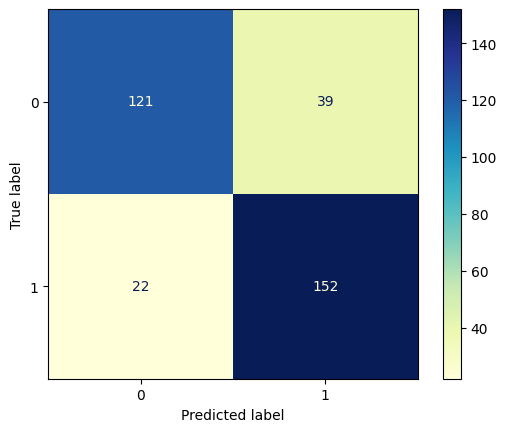

In [24]:
model_trials(cvec_dtree, 'CVec Decision Tree')

In [25]:
tfvec_dtree = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

Title TfVec Decision Tree Training Score: 0.997
Title TfVec Decision Tree Testing Score: 0.71257 

Selftext TfVec Decision Tree Training Score: 0.92579
Selftext TfVec Decision Tree Testing Score: 0.81138 

Title Accuracy Rate: 0.71257
Title Misclassification Rate: 0.28743 

Selftext Accuracy Rate: 0.81138
Selftext Misclassification Rate: 0.18862 

Best accuracy rate confusion matrix:


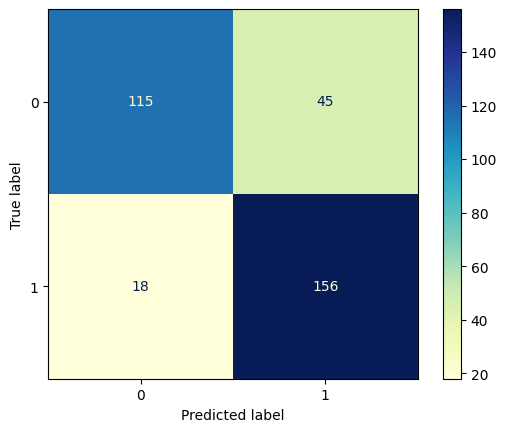

In [26]:
model_trials(tfvec_dtree, 'TfVec Decision Tree')

In [27]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347
2,CVec Mn Naive Bayes,0.943778,0.790419,0.897301,0.829341
3,TfVec Mn Naive Bayes,0.949025,0.775449,0.859070,0.811377
4,CVec KNN,0.691904,0.556886,0.628936,0.547904
5,TfVec KNN,0.614693,0.526946,0.525487,0.520958
6,CVec Decision Tree,0.997001,0.727545,0.925787,0.817365
7,TfVec Decision Tree,0.997001,0.712575,0.925787,0.811377


### Analysis

For both title and selftext, the train scores remained exactly the same using CountVectorizer and TfidfVectorizer. We saw semi-parallel effects on the test scores also, with both decreasing by about .005 - .015 when using Tfidf instead of CVec. 

Adding a max depth and/or min samples to this model would probably reduce the variance slightly, but overall I'd expect Random Forest or a Bagging model to perform better in this context because both are adding randomness to the samples that the Decision Tree model does not.

Though we are overfit on both Decision Tree (and most other model) train/test splits, the selftext scores are relatively high, making this model strong enough to move forward with and see if we can bring down the variance by adjusting the hyperparameters. 

---

## Random Forest Classifier

In [28]:
cvec_rf = Pipeline([
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

Title CVec Random Forest Training Score: 0.997
Title CVec Random Forest Testing Score: 0.75749 

Selftext CVec Random Forest Training Score: 0.92579
Selftext CVec Random Forest Testing Score: 0.81138 

Title Accuracy Rate: 0.75749
Title Misclassification Rate: 0.24251 

Selftext Accuracy Rate: 0.81138
Selftext Misclassification Rate: 0.18862 

Best accuracy rate confusion matrix:


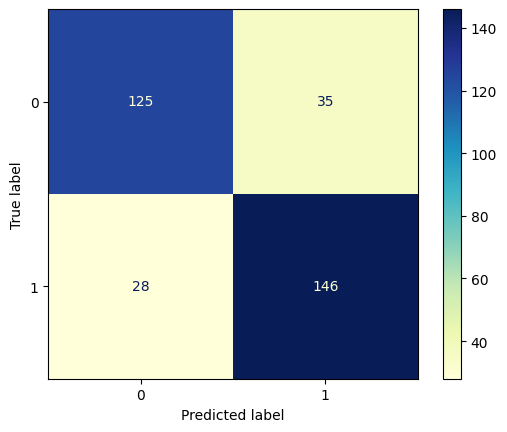

In [29]:
model_trials(cvec_rf, 'CVec Random Forest')

In [30]:
tfvec_rf = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

Title TfVec Random Forest Training Score: 0.997
Title TfVec Random Forest Testing Score: 0.76048 

Selftext TfVec Random Forest Training Score: 0.92579
Selftext TfVec Random Forest Testing Score: 0.80838 

Title Accuracy Rate: 0.76048
Title Misclassification Rate: 0.23952 

Selftext Accuracy Rate: 0.80838
Selftext Misclassification Rate: 0.19162 

Best accuracy rate confusion matrix:


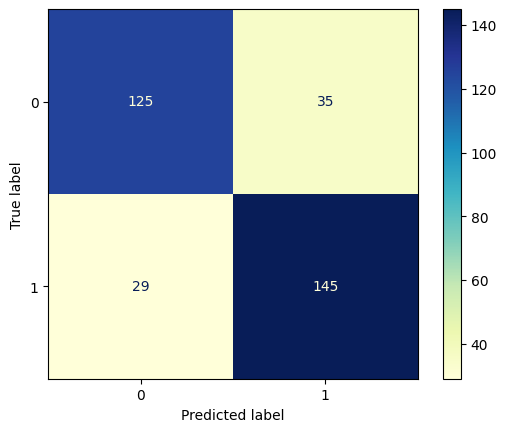

In [31]:
model_trials(tfvec_rf, 'TfVec Random Forest')

In [32]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347
2,CVec Mn Naive Bayes,0.943778,0.790419,0.897301,0.829341
3,TfVec Mn Naive Bayes,0.949025,0.775449,0.859070,0.811377
4,CVec KNN,0.691904,0.556886,0.628936,0.547904
5,TfVec KNN,0.614693,0.526946,0.525487,0.520958
6,CVec Decision Tree,0.997001,0.727545,0.925787,0.817365
7,TfVec Decision Tree,0.997001,0.712575,0.925787,0.811377
8,CVec Random Forest,0.997001,0.757485,0.925787,0.811377
9,TfVec Random Forest,0.997001,0.760479,0.925787,0.808383


### Analysis

Using Tfidf looks to have reclassified one of the true positives as a false negative. Otherwise, both models performed well and had .8+ accuracy rates.

What's more interesting is that the title and selftext train scores for the Decision Tree model (0.997001 and 0.925787, respectively) are exactly the same as the scores seen in the Random Forest model. Switching from Count Vectorizer to Tfidf did not seem to have any effect, either.

Looking at the confusion matrices for these four models, which were generated from the X variable that produced the greatest test score (selftext, in all cases here), we can see that the performance is somewhat homogenous, with the Tfidf Decision Tree and CVec Random Forest models scoring the same on the test set despite making different predictions. 

Both Decision Tree models made more classifications--59%, on average--in the IHateOhio subreddit, leading to more true and false positives. This could mean that this is a better model, or that it performed well in part because it made more predictions of the majority class.

Conversely, the Random Forest models had similar misclassification rates, but leaned a bit more heavily toward Ohio subreddit predictions. In all, the top test-scoring model of the four was the CountVectorizer Decision Tree.

Except for the KNN model, all other confusion matrices have a similar pattern and there seem to be roughly 60-65 posts that are difficult for most models to classify. This is something I'll want to look into as it may be an indication of something I missed during EDA.

---

## Bagging Classifier

In [33]:
cvec_bag_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state=42))
])

Title CVec Bagging Training Score: 0.98351
Title CVec Bagging Testing Score: 0.73054 

Selftext CVec Bagging Training Score: 0.91754
Selftext CVec Bagging Testing Score: 0.81437 

Title Accuracy Rate: 0.73054
Title Misclassification Rate: 0.26946 

Selftext Accuracy Rate: 0.81437
Selftext Misclassification Rate: 0.18563 

Best accuracy rate confusion matrix:


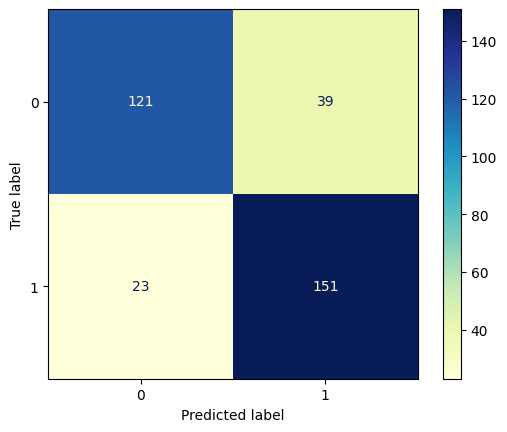

In [34]:
model_trials(cvec_bag_pipe, 'CVec Bagging')

In [35]:
tfvec_bag_pipe = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(random_state=42))
])

Title TfVec Bagging Training Score: 0.97901
Title TfVec Bagging Testing Score: 0.69461 

Selftext TfVec Bagging Training Score: 0.91754
Selftext TfVec Bagging Testing Score: 0.81737 

Title Accuracy Rate: 0.69461
Title Misclassification Rate: 0.30539 

Selftext Accuracy Rate: 0.81737
Selftext Misclassification Rate: 0.18263 

Best accuracy rate confusion matrix:


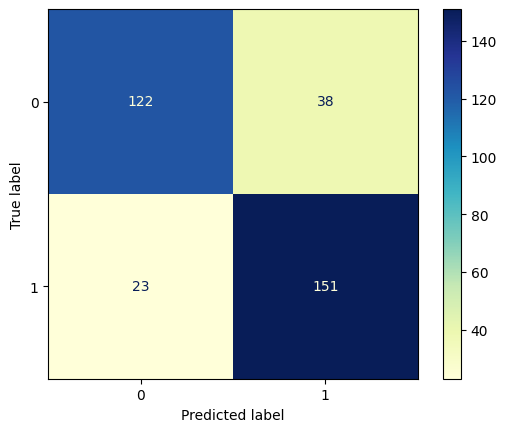

In [36]:
model_trials(tfvec_bag_pipe, 'TfVec Bagging')

### Analysis

Again, using Tfidf led to minimal shifts in classifications, this time with one false positive post being reclassified as a true negative. 

The CountVectorizer Bagging and Decision Tree models made almost identical predictions, meaning my earlier hypothesis that the bagged tree trial would outperform the Decision Tree trial by a wide margin. We can see below that the averaged scores (CVec and Tfidf) for the two are very close.

The Bagging model performed slightly better on the selftext test scores, but worse on most other scores than the previous tree-based models. They do appear to have a tad less variance because the trees are being exposed to different samples of the training set. 

In [37]:
dtree_selftext_test_avg = (model_trials_df['selftext_test_score'][6] + model_trials_df['selftext_test_score'][7]) / 2

bagging_selftext_test_avg = (model_trials_df['selftext_test_score'][10] + model_trials_df['selftext_test_score'][11]) / 2

print(f'Decision Tree Selftext Test Avg: {dtree_selftext_test_avg}')
print(f'Bagging Selftext Test Avg: {bagging_selftext_test_avg}')

Decision Tree Selftext Test Avg: 0.8143712574850299
Bagging Selftext Test Avg: 0.8158682634730539


In [38]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347
2,CVec Mn Naive Bayes,0.943778,0.790419,0.897301,0.829341
3,TfVec Mn Naive Bayes,0.949025,0.775449,0.859070,0.811377
4,CVec KNN,0.691904,0.556886,0.628936,0.547904
5,TfVec KNN,0.614693,0.526946,0.525487,0.520958
6,CVec Decision Tree,0.997001,0.727545,0.925787,0.817365
7,TfVec Decision Tree,0.997001,0.712575,0.925787,0.811377
8,CVec Random Forest,0.997001,0.757485,0.925787,0.811377
9,TfVec Random Forest,0.997001,0.760479,0.925787,0.808383


---

## AdaBoost Classifier

In [39]:
cvec_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state=42))
])

Title CVec AdaBoosting Training Score: 0.75637
Title CVec AdaBoosting Testing Score: 0.7006 

Selftext CVec AdaBoosting Training Score: 0.88156
Selftext CVec AdaBoosting Testing Score: 0.82934 

Title Accuracy Rate: 0.7006
Title Misclassification Rate: 0.2994 

Selftext Accuracy Rate: 0.82934
Selftext Misclassification Rate: 0.17066 

Best accuracy rate confusion matrix:


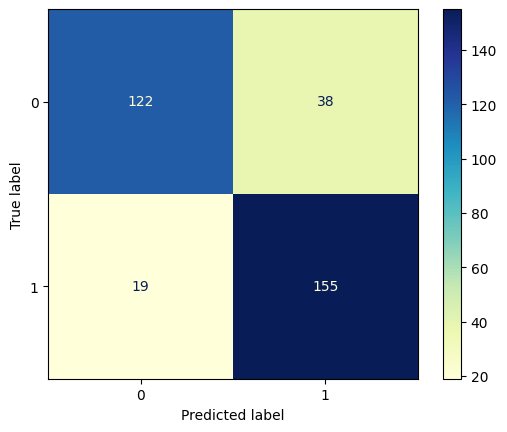

In [40]:
model_trials(cvec_ada, 'CVec AdaBoosting')

In [41]:
tfvec_ada = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(random_state=42))
])

Title TfVec AdaBoosting Training Score: 0.77661
Title TfVec AdaBoosting Testing Score: 0.71856 

Selftext TfVec AdaBoosting Training Score: 0.8973
Selftext TfVec AdaBoosting Testing Score: 0.82934 

Title Accuracy Rate: 0.71856
Title Misclassification Rate: 0.28144 

Selftext Accuracy Rate: 0.82934
Selftext Misclassification Rate: 0.17066 

Best accuracy rate confusion matrix:


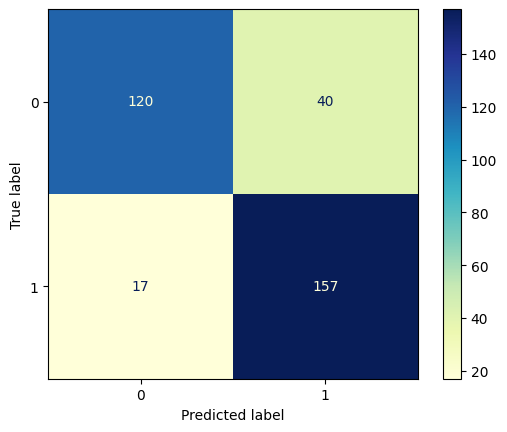

In [42]:
model_trials(tfvec_ada, 'TfVec AdaBoosting')

### Analysis

In terms of the test scores, AdaBoosting appears to be more effective in this dataset than Bagging. 

Using TfVec in the AdaBoost model increased both title scores and the selftext train score, and kept the selftext test score exactly the same. It looks like four posts were reclassified, two correctly and two incorrectly. 

These are now two of the best-scoring models, and there does seem to be significantly less variance in the title and selftext scores than most of the other models. I'm going to try using this same model, but with Logistic Regression as the base estimator because LogReg is one of the other better-performing models we've seen so far.

---

## AdaBoost Classifier with Logistic Regression

In [43]:
cvec_ada_logreg = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

Title CVec AdaBoosting w/ LogReg Training Score: 0.75187
Title CVec AdaBoosting w/ LogReg Testing Score: 0.69461 

Selftext CVec AdaBoosting w/ LogReg Training Score: 0.86732
Selftext CVec AdaBoosting w/ LogReg Testing Score: 0.81138 

Title Accuracy Rate: 0.69461
Title Misclassification Rate: 0.30539 

Selftext Accuracy Rate: 0.81138
Selftext Misclassification Rate: 0.18862 

Best accuracy rate confusion matrix:


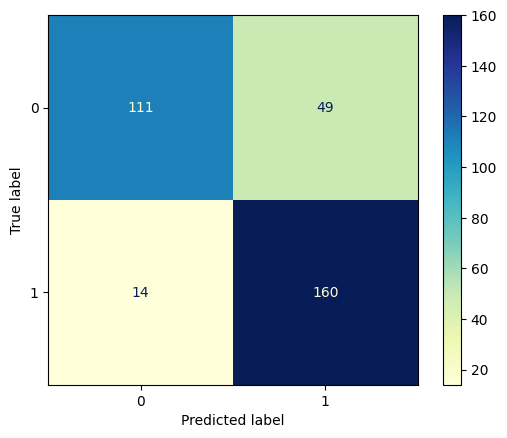

In [44]:
model_trials(cvec_ada_logreg, 'CVec AdaBoosting w/ LogReg')

In [45]:
tfvec_ada_logreg = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

Title TfVec AdaBoosting w/ LogReg Training Score: 0.6934
Title TfVec AdaBoosting w/ LogReg Testing Score: 0.65868 

Selftext TfVec AdaBoosting w/ LogReg Training Score: 0.81484
Selftext TfVec AdaBoosting w/ LogReg Testing Score: 0.79341 

Title Accuracy Rate: 0.65868
Title Misclassification Rate: 0.34132 

Selftext Accuracy Rate: 0.79341
Selftext Misclassification Rate: 0.20659 

Best accuracy rate confusion matrix:


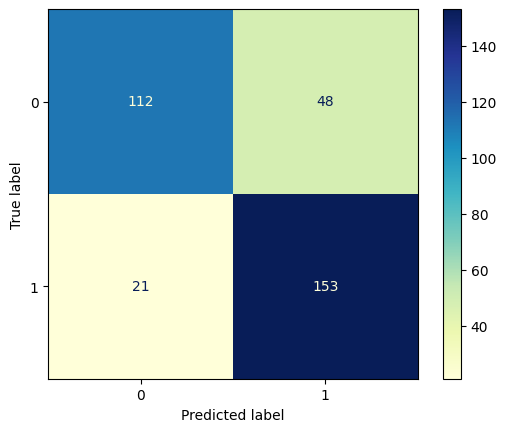

In [46]:
model_trials(tfvec_ada_logreg, 'TfVec AdaBoosting w/ LogReg')

### Analysis

Here we see again the differences between the CountVectorizer and Tfidf interpretations of the text. In this case, CountVectorizer made more predictions for the IHateOhio class and Tfidf incorrectly reclassified seven true positives as false negatives. 

Contrary to my prior hypothesis, using Logistic Regression in conjunction with AdaBoost did not improve the test scores for title or selftext. That being said, these models did still perform relatively well and may be worth exploring further, with hyperparameter tuning.

---

## Gradient Boosting Classifier

In [47]:
cvec_gboost = Pipeline([
    ('cvec', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

Title CVec Gradient Boosting Training Score: 0.80885
Title CVec Gradient Boosting Testing Score: 0.72156 

Selftext CVec Gradient Boosting Training Score: 0.88831
Selftext CVec Gradient Boosting Testing Score: 0.82934 

Title Accuracy Rate: 0.72156
Title Misclassification Rate: 0.27844 

Selftext Accuracy Rate: 0.82934
Selftext Misclassification Rate: 0.17066 

Best accuracy rate confusion matrix:


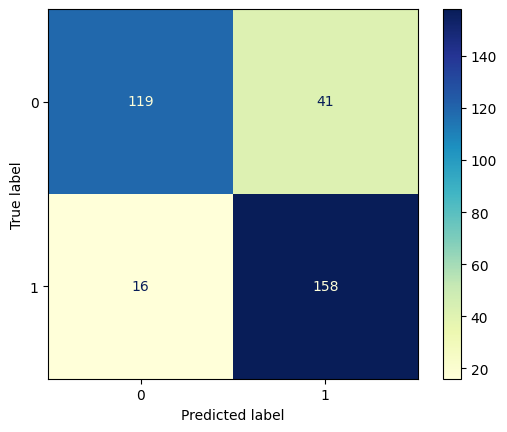

In [48]:
model_trials(cvec_gboost, 'CVec Gradient Boosting')

In [49]:
tfvec_gboost = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

Title TfVec Gradient Boosting Training Score: 0.83058
Title TfVec Gradient Boosting Testing Score: 0.73653 

Selftext TfVec Gradient Boosting Training Score: 0.90255
Selftext TfVec Gradient Boosting Testing Score: 0.82036 

Title Accuracy Rate: 0.73653
Title Misclassification Rate: 0.26347 

Selftext Accuracy Rate: 0.82036
Selftext Misclassification Rate: 0.17964 

Best accuracy rate confusion matrix:


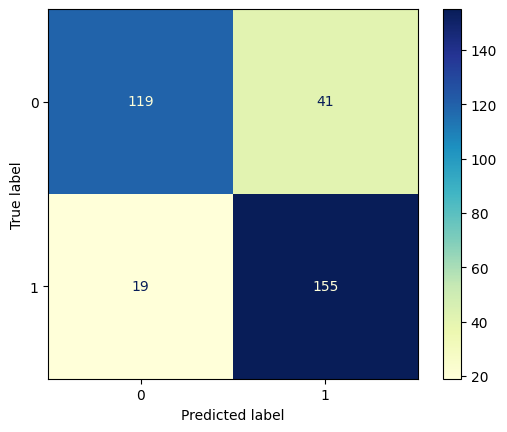

In [50]:
model_trials(tfvec_gboost, 'TfVec Gradient Boosting')

### Analysis

GradientBoosting is another one of the best performing models in terms of average selftext test score, and to my surprise, scored the same as AdaBoost on the CVec trial. Though GBoost did have a handful more false positives than a few other models, it also had some of the lowest false negative predictions. Using Tfidf here looks to have reclassified three true positives as false negatives while all else stayed the same. 

This model scored slightly worse than Bagging on most of the title train and test scores, and the selftext train score. However, the selftext test score jumped by about .015, making GBoost a strong contender for the next level of model trials and adaptations.

---

## Which posts are continuously being misclassified?

In the above matrices, we see a lot of similar patterns, which I think could mean that there is a specific subset of post selftexts that most models are unable to accurately classify.

I'll select a few of the most similar distributions to check for repeated misclassifications.

In [51]:
misclassify_df = pd.DataFrame()

In [52]:
def misclassify(model):
    X = reddit['selftext']
    y = reddit['subreddit_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    true = y_test

    sub_df = pd.DataFrame()
    sub_df['post_text'] = X_test
    sub_df['preds'] = preds
    sub_df['true'] = true

    sub_df = sub_df[sub_df['preds'] != sub_df['true']]

    new_df = pd.concat([misclassify_df, sub_df])

    print(f'This model had {len(sub_df)} misclassifications.')
    return new_df

In [53]:
misclassify(tfvec_mnb)

This model had 63 misclassifications.


,post_text,preds,true
914,i’m from michigan. i live about an hour away from ohio and hate it. as do most people from michigan.\n\nthe reason why i think ohio sucks is firstly for michigan pride. our states are like rivals ...,0,1
863,"my wife is from ohio, i'm from eastern pa. multiple times a year i have to drive into that hell hole and pretend that terrible pizza is good pizza. fuck ohio pizza, fuck ohio.",0,1
969,the thought of how i once moved there and almost wasn’t able to find a way to leave has literally changed me forever ...i have nightmares where i’m back there and have to stay for my whole life,0,1
874,is ohio real? i’ve never been there so ohio is fake,0,1
804,coming from a 24 ur old female so. cal resident\n\nthe stories i hear that is unbelievable or utterly disturbing/disgusting. they just keep coming. what the fuck is wrong with ohio? \n\nfrom a spi...,0,1
...,...,...,...
909,just had to move to ohio from west virginia and how is there even less to do here than there is at home? the people are so rude over here it’s like they live to piss you off or they can sense i’m ...,0,1
836,i have done a good job getting out of toledo and staying away. but an uncle is sick now and i have to go back.\n\nwhere to go afternoons in toledo when i'm not at the hospital?,0,1
27,,1,0
922,how do you hate ohio? it doesn't even exist,0,1


In [54]:
misclassify_df = pd.concat([misclassify(tfvec_mnb), misclassify(tfvec_dtree), misclassify(cvec_rf), misclassify(cvec_bag_pipe), misclassify(cvec_ada_logreg)])
misclassify_df.shape

This model had 63 misclassifications.
This model had 63 misclassifications.
This model had 63 misclassifications.
This model had 62 misclassifications.
This model had 63 misclassifications.


(314, 3)

In [58]:
misclassify_df['count'] = misclassify_df.index.value_counts()

In [59]:
three_plus_times = misclassify_df[misclassify_df['count'] > 2]
three_plus_times.drop_duplicates(subset='post_text', inplace=True)

,post_text,preds,true,count
863,"my wife is from ohio, i'm from eastern pa. multiple times a year i have to drive into that hell hole and pretend that terrible pizza is good pizza. fuck ohio pizza, fuck ohio.",0,1,3
969,the thought of how i once moved there and almost wasn’t able to find a way to leave has literally changed me forever ...i have nightmares where i’m back there and have to stay for my whole life,0,1,5
804,coming from a 24 ur old female so. cal resident\n\nthe stories i hear that is unbelievable or utterly disturbing/disgusting. they just keep coming. what the fuck is wrong with ohio? \n\nfrom a spi...,0,1,5
677,,1,0,5
1012,for the love of god someone save me the allergens are killing me and it was snowy until april,0,1,5


In [60]:
three_plus_times

,post_text,preds,true,count
863,"my wife is from ohio, i'm from eastern pa. multiple times a year i have to drive into that hell hole and pretend that terrible pizza is good pizza. fuck ohio pizza, fuck ohio.",0,1,3
969,the thought of how i once moved there and almost wasn’t able to find a way to leave has literally changed me forever ...i have nightmares where i’m back there and have to stay for my whole life,0,1,5
804,coming from a 24 ur old female so. cal resident\n\nthe stories i hear that is unbelievable or utterly disturbing/disgusting. they just keep coming. what the fuck is wrong with ohio? \n\nfrom a spi...,0,1,5
677,,1,0,5
1012,for the love of god someone save me the allergens are killing me and it was snowy until april,0,1,5
802,"i went to ohio for a few weeks once. don’t know if that counts me as an ohioan, but i am definitely recovering.",0,1,4
1045,who the hell names themselves after a poisonous nut that is also useless in every other way?,0,1,4
647,realize i live near a field of stone corn,1,0,4
1027,i just moved to cincinnati from austin tx and what the fuck does anyone do here i absolutely despise ohio someone please nuke us,0,1,3
844,only 2 or 3 things to do here. gets boring very fast.,0,1,4


In [65]:
print(misclassify_df['preds'].value_counts())
print(misclassify_df['true'].value_counts())

1    196
0    118
Name: preds, dtype: int64
0    196
1    118
Name: true, dtype: int64


There does not seem to be one common thread that ties all of the misclassifications that we see above together. Based on the pred and true counts, we can see that most errors made by the models are incorrect IHateOhio predictions, which should actually be Ohio classifications.

The most obvious observations here are the empty strings and anything written in a different language.  This makes sense in that these are vague for a machine - any nulls or captions written in a language that the model is not looking for are relatively neutral expressions, which explains why the models continuously have a hard time with these and resort to simply (and incorrectly) predicting the majority class. 

The posts that do not have either of the two features mentioned above seem like they should be easier for models to correctly guess the classifications for, but the language in a few is also confusing for a computer. For instance, the post "for the love of god someone save me the allergens are killing me and it was snowy until april" is pretty clear to a human (who speaks English) reading it that this person is not fond of Ohio. However, the post was misclassified in all five of the models tested, and likely in more models above. I think that "love" in this sentence is throwing the models off because they are not interpreting the context of the sentence as a whole.

Another issue in the model is locations. I'm theorizing that mentions of state names or Ohio city names are more common in the Ohio subreddit. This results in a high likelihood of misclassification when these appear in the IHateOhio subreddit. In the three_plus_times dataframe above, we see that all posts that include any substrings like "cincinatti," "toledo," "cleveland," "texas," "nyc," etc. were predicted to be from the Ohio thread but were actually all from the IHateOhio sub.

In future models, I would try to account for these issues in the model by:
1. Removing blanks, emojis, other languages, and any other posts that are not relevant to the problem statement.
2. Add my own stop words to give the models a better understanding of what to look for and what to ignore.
3. Instead of splitting the title and selftext sections and scoring separately, I'd be curious to see if combining the two would lead to a more cohesive message for the model and therefore, higher scores.

---

## Model Evaluation

In [62]:
model_trials_df.to_csv('../datasets/model_trials_no_https.csv')

model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347
2,CVec Mn Naive Bayes,0.943778,0.790419,0.897301,0.829341
3,TfVec Mn Naive Bayes,0.949025,0.775449,0.859070,0.811377
4,CVec KNN,0.691904,0.556886,0.628936,0.547904
5,TfVec KNN,0.614693,0.526946,0.525487,0.520958
6,CVec Decision Tree,0.997001,0.727545,0.925787,0.817365
7,TfVec Decision Tree,0.997001,0.712575,0.925787,0.811377
8,CVec Random Forest,0.997001,0.757485,0.925787,0.811377
9,TfVec Random Forest,0.997001,0.760479,0.925787,0.808383


In [63]:
model_trials_df.describe()

,title_train_score,title_test_score,selftext_train_score,selftext_test_score
count,18.000000,18.000000,18.000000,18.000000
mean,0.870023,0.712409,0.859445,0.787591
std,0.128837,0.071698,0.108135,0.092950
min,0.614693,0.526946,0.525487,0.520958
25%,0.761432,0.696108,0.868066,0.811377
50%,0.936657,0.724551,0.897301,0.815868
75%,0.982384,0.759731,0.917541,0.828593
max,0.997001,0.793413,0.925787,0.847305


The average accuracy among the test scores was 0.75, which is not as high as I'd like and indicates that there are misclassifications that can be tuned and, ideally, reclassified correctly.

The highest mean score as well as the maximum score were both seen in the title train score, which I think is mostly due to overfitting. The second highest mean score was seen in the selftext train scores, but this column also had the second-greatest standard devation. The title test score had the lowest mean of the four, but also had the least deviation from the mean.

The only model that performed better using the title column as X instead of selftext, as shown in the dataframe above and also in the colors of their confusion matrices, was KNN. All other models either moderately or strongly preferred the selftext as X.

Further, the test scores are, in my opinion, the most important when deciding which models to proceed with. As the selftext column had the highest average test score, this is how I'll be choosing which models to keep using with varied hyperparameters.

In [64]:
model_trials_df[['model_used', 'selftext_test_score']].sort_values(by=['selftext_test_score'], ascending=False).head(10)

,model_used,selftext_test_score
0,CVec Logistic Regression,0.847305
2,CVec Mn Naive Bayes,0.829341
16,CVec Gradient Boosting,0.829341
13,TfVec AdaBoosting,0.829341
12,CVec AdaBoosting,0.829341
1,TfVec Logistic Regression,0.826347
17,TfVec Gradient Boosting,0.820359
6,CVec Decision Tree,0.817365
11,TfVec Bagging,0.817365
10,CVec Bagging,0.814371


Above are the top ten highest selftext test scores. We see an almost even split between CountVectorizer and Tfidf, which probably has less to do with the vectorizers themselves and more to do with the models that were using them.

We also see quite a few repeats in here - Logistic Regression, Gradient Boosting, Bagging, and Ada Boosting (sans Logistic Regression) - meaning the same model showing up twice, once for each vectorizer. The Boosting models outperformed the Bagging models in all trials, indicating that the method of random sampling and adjusting the observation weight based on the previous classification is more effective on this dataset than simple random sampling with replacement.

Moving into the model tuning, I'll be employing GridSearch to find the optimal hyperparameters and the highest-scoring model overall.

I was incorrect in my earlier prediction that using the title as X would lead to better results. Despite the sentiment scores and missing values, selftext out-scored title by a wide margin in all but two models. 

Based on the scores above, I do still believe that I'll be able to meet my problem statement goal building a final model that classifies with at least 85% accuracy.